# PSUPR / PRMLS CA2

### Team
Kenneth Goh Chia Wei : A0198544N  
Tan Heng Han : A0198502B  
Raymond Ng Boon Cheong : A0198543R

In [181]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import pprint
import lxml
import re
import os
import glob
import gensim
import time
import warnings
from collections import Counter

from bs4 import BeautifulSoup
import nltk
# nltk.download('stopwords')
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM, Bidirectional
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical

warnings.filterwarnings('ignore')

## Create a function for cleaning up tweets
Reference: https://towardsdatascience.com/another-twitter-sentiment-analysis-bb5b01ebad90

In [182]:
# Init WordPunctTokenizer
tok = WordPunctTokenizer()
# create reg expression
pat1 = r'@[A-Za-z0-9]+'
pat2 = r'https?://[A-Za-z0-9./]+'
combined_pat = r'|'.join((pat1, pat2))

def tweet_cleaner(text):
    # Use beautiful soup to decode html to text
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    # strip text using regular expression
    stripped = re.sub(combined_pat, '', souped)
    try:
        clean = stripped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        clean = stripped
    # strip to letters only
    letters_only = re.sub("[^a-zA-Z]", " ", clean)
    # remove retweets handle
    removed_rt = re.sub('RT ','',letters_only)
    # set to lower case for all characters
    lower_case = removed_rt.lower()
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = tok.tokenize(lower_case)
    return (" ".join(words)).strip()

### Load Data from csv
Read all tweets from their respective csv and append everything into a single dataframe. Use directory name for their respective label.

In [183]:
dataset_directories = {
    'happy': '..\dataset\happy',
    'sad': '..\dataset\sad',
    'angry': '..\dataset\\angry',
}

def getTweetsFromCSV(directory):
    files = glob.glob(directory + '\*.csv')
    dfs = [pd.read_csv(f) for f in files]
    dfs_combined = pd.concat(dfs, ignore_index=True)
    return dfs_combined

In [184]:
%%time
dfs = []
for directory in dataset_directories:
    all_dfs = getTweetsFromCSV(dataset_directories[directory])
    all_dfs['label'] = directory
    dfs.append(all_dfs)

df_col = dfs[0].columns
final = pd.concat(dfs, ignore_index=True)
df = pd.DataFrame(final, columns=df_col)

Wall time: 262 ms


In [185]:
df.head()

,text,weekday,month,day,hour,has_hashtag,has_url,fav_count,is_reply,retweet_count,followers,following,user,screen_name,label
0,CRUSH GAME: Describe your crush\n\n1. slightly...,Thu,Sep,12,13,0,1,0,0,0,39,100,+,melliflcus,happy
1,RT @Emolclause: #BREAKING:Now we find out that...,Thu,Sep,12,13,1,0,0,0,157,280,605,Kathleen A. English,kenglishesq1,happy
2,@susie_meister Bless your heart! The neighbor ...,Thu,Sep,12,13,0,1,1,1,0,415,868,Gabrielle,DGCBcardiac96,happy
3,RT @ajimatanrareje: Wow!!! Somethings are bett...,Thu,Sep,12,13,1,1,0,0,1,122,281,Foluso John Gbadebo.,jfoluso,happy
4,@realDonaldTrump Mexico. Wall. Pay. Didn't kno...,Thu,Sep,12,13,0,1,0,1,0,44,82,Paul Gordon,NoJob1263,happy


In [186]:
df.shape

(22460, 15)

In [187]:
text = df['text']
label = df['label']
text.head()

0    CRUSH GAME: Describe your crush\n\n1. slightly...
1    RT @Emolclause: #BREAKING:Now we find out that...
2    @susie_meister Bless your heart! The neighbor ...
3    RT @ajimatanrareje: Wow!!! Somethings are bett...
4    @realDonaldTrump Mexico. Wall. Pay. Didn't kno...
Name: text, dtype: object

In [188]:
label.head()

0    happy
1    happy
2    happy
3    happy
4    happy
Name: label, dtype: object

### Clean up all tweets
Call the _tweet_cleaner_ method to process all tweets in the dataframe

In [189]:
cleaned_tweets = []
for tweet in text:
    cleaned_tweets.append(tweet_cleaner(tweet))
print((cleaned_tweets[:5]))
print(f'Tweets total: {len(cleaned_tweets)}')

['crush game describe your crush slightly taller older floof noooo nooo school', 'breaking now we find out that pence needlessly cost taxpayers shuttling back and forth from dunlin to trump', 'meister bless your heart the neighbor had to sell his house and move because of all the money his stupidity', 'wow somethings are better explained visually sad', 'mexico wall pay didn t know the armed forces budget was in pesos since they ve been ordered to']
Tweets total: 22460


### Rejoin all tweets and remove duplicated tweets

In [190]:
finalDF = pd.DataFrame({'text': cleaned_tweets, 'label': label})
finalDF.drop_duplicates(subset='text', inplace=True, keep='first')

In [191]:
finalDF.shape

(10176, 2)

In [192]:
finalDF.head()

,text,label
0,crush game describe your crush slightly taller...,happy
1,breaking now we find out that pence needlessly...,happy
2,meister bless your heart the neighbor had to s...,happy
3,wow somethings are better explained visually sad,happy
4,mexico wall pay didn t know the armed forces b...,happy


### Display label distributions

Text(0.5, 1.0, 'Tweets Label Distro')

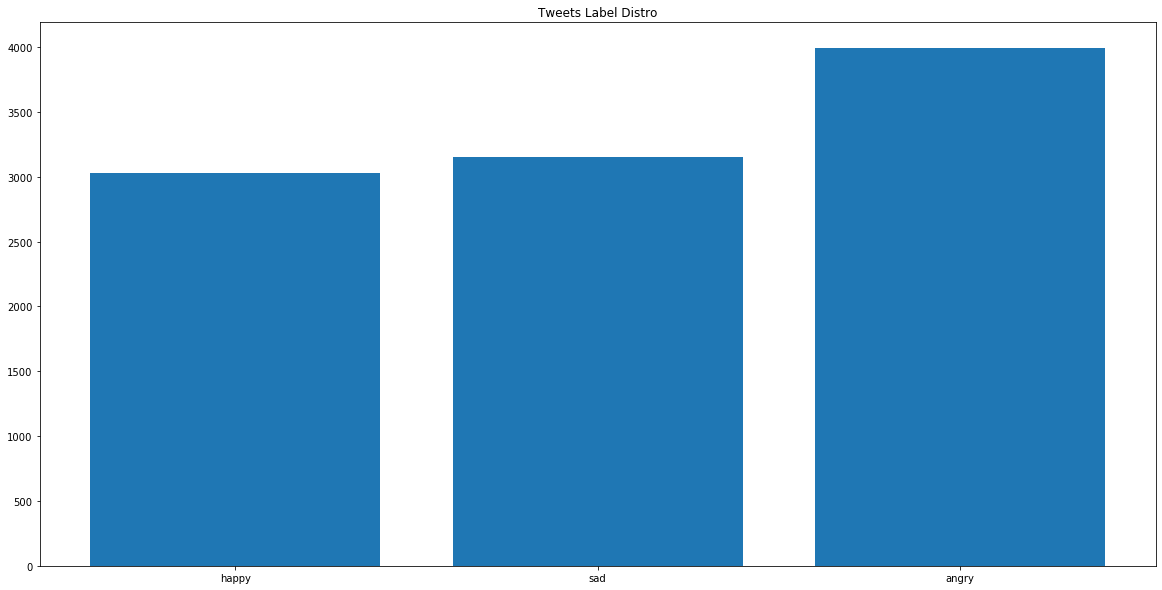

In [193]:
label_count = Counter(finalDF.label)

plt.figure(figsize=(20, 10))
plt.bar(label_count.keys(), label_count.values())
plt.title('Tweets Label Distro')

### Preprocess Dataset

In [194]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

In [195]:
# TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
    # Remove link,user and special characters
#     text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [196]:
%%time
finalDF.text = finalDF.text.apply(lambda x: preprocess(x))

Wall time: 236 ms


In [197]:
finalDF.iloc[0][0]

'crush game describe crush slightly taller older floof noooo nooo school'

### Train, Test set split

In [198]:
# X_train, X_test, y_train, y_test = train_test_split(finalDF.text, finalDF.label, test_size=0.2, random_state=42)
X_train, X_test = train_test_split(finalDF, test_size=0.2, random_state=42)

In [199]:
X_train.head()

,text,label
15015,commonly used antibiotics may lead heart probl...,sad
16335,talking children healthy expressions anger dra...,angry
10292,anxiety way anxiety anxietyrelief pain hurting...,sad
13065,reposting via selfesteem selflove selfcare con...,sad
18275,side note follow brawls rotation unless playin...,angry


In [200]:
%%time
documents = [_text.split() for _text in X_train.text]

Wall time: 13 ms


In [201]:
w2v_model = gensim.models.word2vec.Word2Vec(size=300,
                                            window=7,
                                           min_count=10,
                                           workers=8)

In [202]:
%%time
w2v_model.build_vocab(documents)

Wall time: 258 ms


In [203]:
words = w2v_model.wv.vocab.keys()
vocab_size=len(words)
print("Vocab size:", vocab_size)

Vocab size: 1327


In [204]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=32)

Wall time: 1.27 s


(1295327, 2443648)

In [205]:
w2v_model.most_similar("love")

[('sweet', 0.8859485983848572),
 ('spread', 0.878990650177002),
 ('nature', 0.8694828152656555),
 ('soul', 0.863410234451294),
 ('loving', 0.8551695346832275),
 ('peace', 0.8314659595489502),
 ('sing', 0.8304579257965088),
 ('joytrain', 0.8274024724960327),
 ('rainbow', 0.8248344659805298),
 ('kindness', 0.8182334899902344)]

### Tokenize Text

In [206]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(documents)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 17295
Wall time: 90.5 ms


In [207]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(documents), maxlen=300)
x_test = pad_sequences(tokenizer.texts_to_sequences(documents), maxlen=300)

Wall time: 144 ms


In [208]:
labels = finalDF.label.unique().tolist()
labels

['happy', 'sad', 'angry']

In [209]:
encoder = LabelEncoder()
# encoder = OneHotEncoder()
encoder.fit(X_train.label)

y_train = encoder.transform(X_train.label)
y_test = encoder.transform(X_test.label)

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train_labels = to_categorical(y_train, num_classes=3)
y_test_labels = to_categorical(y_test, num_classes=3)
len(y_test_labels)

y_train (8140, 1)
y_test (2036, 1)


2036

In [210]:
embedding_matrix = np.zeros((vocab_size, 300))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(17295, 300)


In [211]:
embedding_layer = Embedding(vocab_size, 300, weights=[embedding_matrix], input_length=300, trainable=False)

In [212]:
model = Sequential()
model.add(embedding_layer)
# model.add(Dropout(0.5))
# model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# model.add(Dense(1, activation='sigmoid'))

# model.add(embedding_layer)
model.add(Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(24, activation='relu'))
model.add(Dense(3, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 300, 300)          5188500   
_________________________________________________________________
bidirectional_5 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_9 (Dense)              (None, 24)                4824      
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 75        
Total params: 5,514,199
Trainable params: 325,699
Non-trainable params: 5,188,500
_________________________________________________________________


In [213]:
model.compile(loss='categorical_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [214]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [215]:
%%time
history = model.fit(x_train, y_train_labels,
                    batch_size=32,
                    epochs=8,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Train on 7326 samples, validate on 814 samples
Epoch 1/8
7326/7326 [==============================] - 203s 28ms/step - loss: 0.7425 - acc: 0.6810 - val_loss: 0.6226 - val_acc: 0.7346
Epoch 2/8
7326/7326 [==============================] - 193s 26ms/step - loss: 0.6041 - acc: 0.7422 - val_loss: 0.5749 - val_acc: 0.7432
Epoch 3/8
7326/7326 [==============================] - 181s 25ms/step - loss: 0.5535 - acc: 0.7589 - val_loss: 0.5465 - val_acc: 0.7629
Epoch 4/8
7326/7326 [==============================] - 181s 25ms/step - loss: 0.5250 - acc: 0.7679 - val_loss: 0.5335 - val_acc: 0.7654
Epoch 5/8
7326/7326 [==============================] - 193s 26ms/step - loss: 0.4975 - acc: 0.7800 - val_loss: 0.5101 - val_acc: 0.7690
Epoch 6/8
7326/7326 [==============================] - 183s 25ms/step - loss: 0.4804 - acc: 0.7875 - val_loss: 0.4903 - val_acc: 0.7789
Epoch 7/8
7326/7326 [==============================] - 195s 27ms/step - loss: 0.4718 - acc: 0.7879 - val_loss: 0.4899 - val_acc: 0.7789
E

In [216]:
%%time
# len(X_test)
score = model.evaluate(X_test, y_test_labels, batch_size=32)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

ValueError: Error when checking input: expected embedding_3_input to have shape (300,) but got array with shape (2,)

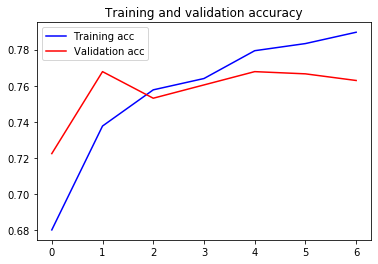

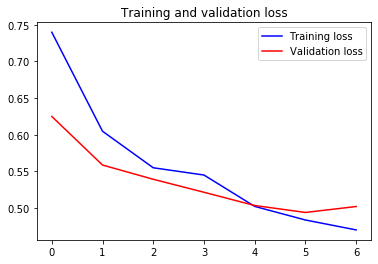

In [176]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

In [36]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [37]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}  

In [38]:
predict()

TypeError: predict() missing 1 required positional argument: 'text'

In [177]:
%%time
y_pred_1d = []
y_test_1d = list(df_test.target)
scores = model.predict(x_test, verbose=1, batch_size=8000)
y_pred_1d = [decode_sentiment(score, include_neutral=False) for score in scores]

NameError: name 'df_test' is not defined

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=22)
    plt.yticks(tick_marks, classes, fontsize=22)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=25)
    plt.xlabel('Predicted label', fontsize=25)

In [ ]:
%%time

cnf_matrix = confusion_matrix(y_test_1d, y_pred_1d)
# plt.figure(figsize=(12,12))
# plot_confusion_matrix(cnf_matrix, classes=df_train.target.unique(), title="Confusion matrix")
# plt.show()

In [ ]:
print(classification_report(y_test_1d, y_pred_1d))

In [ ]:
accuracy_score(y_test_1d, y_pred_1d)